In [5]:
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

% matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)
sns.set_style("darkgrid")

% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Data

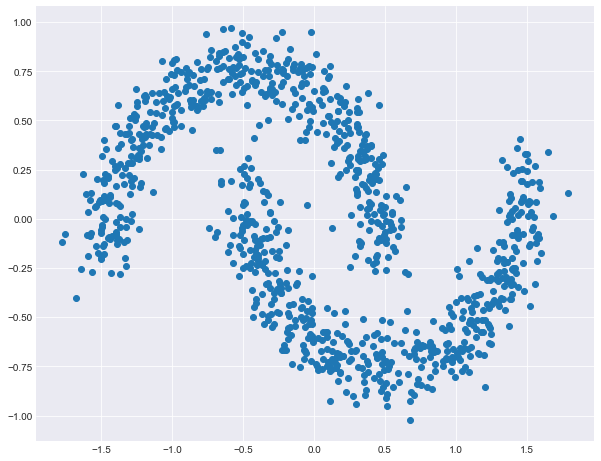

In [6]:
from phd_lib.datasets import halfmoon
from phd_lib.datasets import data_utils

data = halfmoon.get_half_moon()[0]
data = torch.Tensor(data)
full_space = data_utils.linspace_2d(-2, 2, -1.5, 1.5, num=10000)

plt.scatter(data[:, 0], data[:, 1])

### Define Networks

In [7]:
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from torch.distributions.multivariate_normal import MultivariateNormal


class Discriminator(torch.nn.Module):
    
    def __init__(self, n_hidden=10, activation=F.relu):
        super(Discriminator, self).__init__()
        self.l_in = torch.nn.Linear(2, n_hidden)
        self.l_h1 = torch.nn.Linear(n_hidden, n_hidden)
        self.l_out = torch.nn.Linear(n_hidden, 2)
        self.activation = activation
        
    def forward(self, x):
        x = self.activation(self.l_in(x))
        x = self.activation(self.l_h1(x))
        x = self.l_out(x)
        return x


class Generator(torch.nn.Module):
    
    def __init__(self, n_in=2, n_hidden=10, activation=F.relu):
        super(Generator, self).__init__()
        self.n_in = n_in
        self.l_in = torch.nn.Linear(n_in, n_hidden)
        self.l_h1 = torch.nn.Linear(n_hidden, n_hidden)
        self.l_out = torch.nn.Linear(n_hidden, 2)
        self.activation = activation
        
    def forward(self, x):
        x = self.activation(self.l_in(x))
        x = self.activation(self.l_h1(x))
        x = self.l_out(x)
        return x
    
    def gen_noise(self, size):
        return MultivariateNormal(torch.zeros(self.n_in), torch.eye(self.n_in)).sample((size, ))

### Define Losses

In [8]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

        
def get_G_loss(X, G, D):
    G.zero_grad()
    z = G.gen_noise(len(X))
    
    loss_func = CrossEntropyLoss()
    loss_real = loss_func(D(X), torch.zeros(len(X), dtype=torch.long)) # 0 - want D to be wrong (real is 1)
    loss_fake = loss_func(D(G(z)), torch.ones(len(X), dtype=torch.long)) # 1 -  want D to be wrong (fake is 0)
    loss = loss_fake
    
    set_requires_grad(D, False)
    set_requires_grad(G, True)
    return loss


def get_D_loss(X, G, D):
    D.zero_grad()
    z = G.gen_noise(len(X))
    
    loss_func = CrossEntropyLoss()
    loss_real = loss_func(D(X), torch.ones(len(X), dtype=torch.long)) # 1 - want D to be right (real is 1)
    loss_fake = loss_func(D(G(z)), torch.zeros(len(X), dtype=torch.long)) # 0 -  want D to be right (fake is 0)
    loss = loss_fake + loss_real
    
    set_requires_grad(D, True)
    set_requires_grad(G, False)
    return loss

### Plots and Animation

In [9]:
def plot_results(G, D, logger, full_space, real_data, n_synth=1000, figsize=(10, 12)):
    
    f, ax = plt.subplots(nrows=2, figsize=figsize, gridspec_kw={'height_ratios':[5, 1]})
    
    full_out = D(torch.Tensor(full_space))
    full_out = F.softmax(full_out, dim=1)
    full_out = full_out.detach().numpy()[:, 0]
    synth_data = G(G.gen_noise(n_synth)).numpy()

    ax[0].set_title("decision boundary")
    ax[0].scatter(full_space[:, 0], full_space[:, 1], cmap="coolwarm", c=full_out, vmin=-0.2, vmax=1.2)
    ax[0].scatter(synth_data[:, 0], synth_data[:, 1], c="red", s=8, label="synth")
    ax[0].scatter(real_data[:, 0], real_data[:, 1], c="blue", s=8, label="real")
    ax[0].set_xlim((-2, 2))
    ax[0].set_ylim((-1.5, 1.5))
    ax[0].legend()
    
    logger.plot("loss", ax=ax[1])
    
    plt.show()


In [46]:
def animate(logger, full_space, real_data, skip_frames=3):
    start_time = time.time()
    n_epochs = len(logger["G_loss"])
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 12), gridspec_kw={'height_ratios': [5, 1]})
    ax[0].set(xlim=(-2, 2), ylim=(-1.5, 1.5))
    ax[1].set(xlim=(0, n_epochs))

    viz = ["real_data", "decision_boundary", "synth_data", "G_loss", "D_loss"]  # just for ref

    full_out = logger["decision_boundary"][-1].detach().numpy()[:, 0]
    viz[1] = ax[0].scatter(full_space[:, 0], full_space[:, 1], cmap="coolwarm", c=full_out, vmin=-0.2, vmax=1.2)
    synth_data = logger["generator_sample"][-1]
    viz[2] = ax[0].scatter(synth_data[:, 0], synth_data[:, 1], c="red", s=8)
    viz[3], = ax[1].plot(logger["G_loss"], label="G_loss")
    viz[4], = ax[1].plot(logger["D_loss"], label="D_loss")
    ax[1].legend()
    

    def init():
        viz[0] = ax[0].scatter(real_data[:, 0], real_data[:, 1], s=7.5, c="blue")
        return viz

    def update(i):
        i = skip_frames * i 
        full_out = logger["decision_boundary"][i].detach().numpy()[:, 0]
        viz[1].set_color(plt.cm.coolwarm(full_out))
        viz[2].set_offsets(logger["generator_sample"][i])
        viz[3].set_data(range(i), logger["G_loss"][:i])
        viz[4].set_data(range(i), logger["D_loss"][:i])
        return viz

    anim = FuncAnimation(fig, update, interval=100, frames=n_epochs // skip_frames, repeat=False, blit=True, init_func=init)
    res = anim.to_html5_video()
    plt.close()
    print("{:.2f}s".format(time.time() - start_time))
    return res

### Training

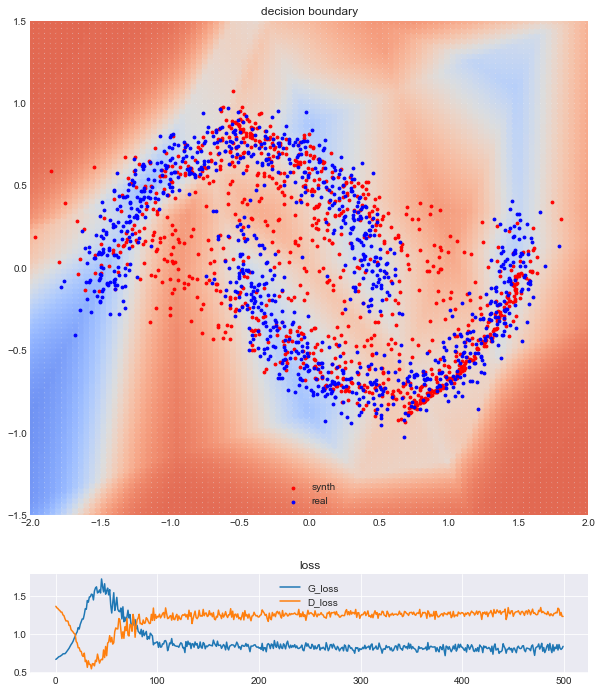

In [50]:
from torch.optim import Adam
from phd_lib.batchers.batcher import Batcher
from phd_lib.loggers.train_logger import TrainLogger


n_epochs = 500
batch_size = 100

G = Generator(n_in=3, n_hidden=15)
D = Discriminator(n_hidden=10)
batcher = Batcher(data)
logger = TrainLogger()
G_optim = Adam(G.parameters(), lr=1e-4)
D_optim = Adam(D.parameters(), lr=1e-3)


for ix_epoch in range(n_epochs):
    
    for batch in batcher.gen_batches(batch_size):
        get_D_loss(batch, G, D).backward()
        D_optim.step()

    for batch in batcher.gen_batches(batch_size):
        get_G_loss(batch, G, D).backward()
        G_optim.step()
        
    logger.add("G_loss", get_G_loss(batch, G, D))
    logger.add("D_loss", get_D_loss(batch, G, D))
    logger.add("decision_boundary", F.softmax(D(torch.Tensor(full_space)), dim=1))
    logger.add("generator_sample", G(G.gen_noise(500)).numpy())


plot_results(G, D, logger, full_space, data) 

### Gorgeous animation

In [51]:
video = animate(logger, full_space, data)
HTML(video)

28.09s
